### NOTE: My contribution for the Alan Turing Institute Data Science event

I was very glad to having participated in the 3-days long event organized by the Alan Turing Institute where a lot of interesting ideas revolving AI were discussed. Topics included AI's role in tackling climate emergency, public policy making and the future of machine intelligence. I was also part of a data science group where we've been tasked on solving a machine learning problem aimed at classifying twitter messages as either pro-climate-emergency or denier of it. Sadly, I had to leave the online discussion group since I had another meeting. This notebook contains some contributions which I've liked to share on this interesting problem. The original notebook is found at https://github.com/alan-turing-institute/DSGaiuk2022. This version has been heavily modified, since the original had about 5 issues where we explore ML techniques to address them. In this notebook, I'm simply tackling the problem described above. 


# AI UK Challenge Instructions (Modified from the original)

## Run setup

In [1]:
"""
To run this notebook in Google Colab, you need to the following first:
1. Open this link: https://drive.google.com/drive/folders/1adprVKMxSlXTn-S3ZAbOx545cxv5CzHl?usp=sharing
2. Then go to "Shared with me" in your Google Drive, right-click the "AIUK" folder
and select "Add shortcut to Drive"

Optionally, if you don't have a Google Drive account, you can set colab to False,
and download the data.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from pathlib import Path

%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (15,10)

colab = False

if colab:
    from google.colab import drive
    drive.flush_and_unmount()
    drive.mount('/content/drive')
    root_dir = Path('/content/drive/MyDrive/AIUK')
else:
    from data import download_data
    #download_data()  # I've already downloaded the data
    root_dir = Path('./')

There were about 4 problems which sought to use linear regression to quantify the relationship between variables of interest such as countries and emitted CO2, to predict sea level across time, so on and so forth. The topics were:
##  Climate change indicators dataset
## CO2
## Temperature changes
## Sea level
## Predicting sea level rise

<img src="https://cloudfront-us-east-2.images.arcpublishing.com/reuters/3XK6LJVMXBMXZMBV45JCDUZN6Y.jpg">


# Climate change sentiment dataset (the one our data science group worked with)

Beyond the bare numbers, combating climate change will require buy-in from people in all walks of life. Part of persuading people about the need to combat the deadly outcomes of global warming is identifying which parts of the population are already persuaded, and what evidence each side is deploying to support their point of view.

We've provided a dataset includes a large group of social media posts related to climate change, annotated by human experts as referring to either factual news sources (2), or as opinion indicating that the person is promoting either belief or disbelief in anthropogenic warming (1 or -1). Messages without an obvious valence are marked with a 0.

You can find that dataset in your Google Drive at /content/drive/MyDrive/AIUK/cc_sentiment.csv

Dataset source: https://www.kaggle.com/edqian/twitter-climate-change-sentiment-dataset

In [2]:
data = pd.read_csv(root_dir.joinpath('cc_sentiment.csv'))
data.head()

,sentiment,message,tweetid
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840
1,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641
2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256
3,1,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125156185137153


Let's see how many examples of each class we have in our dataset. 

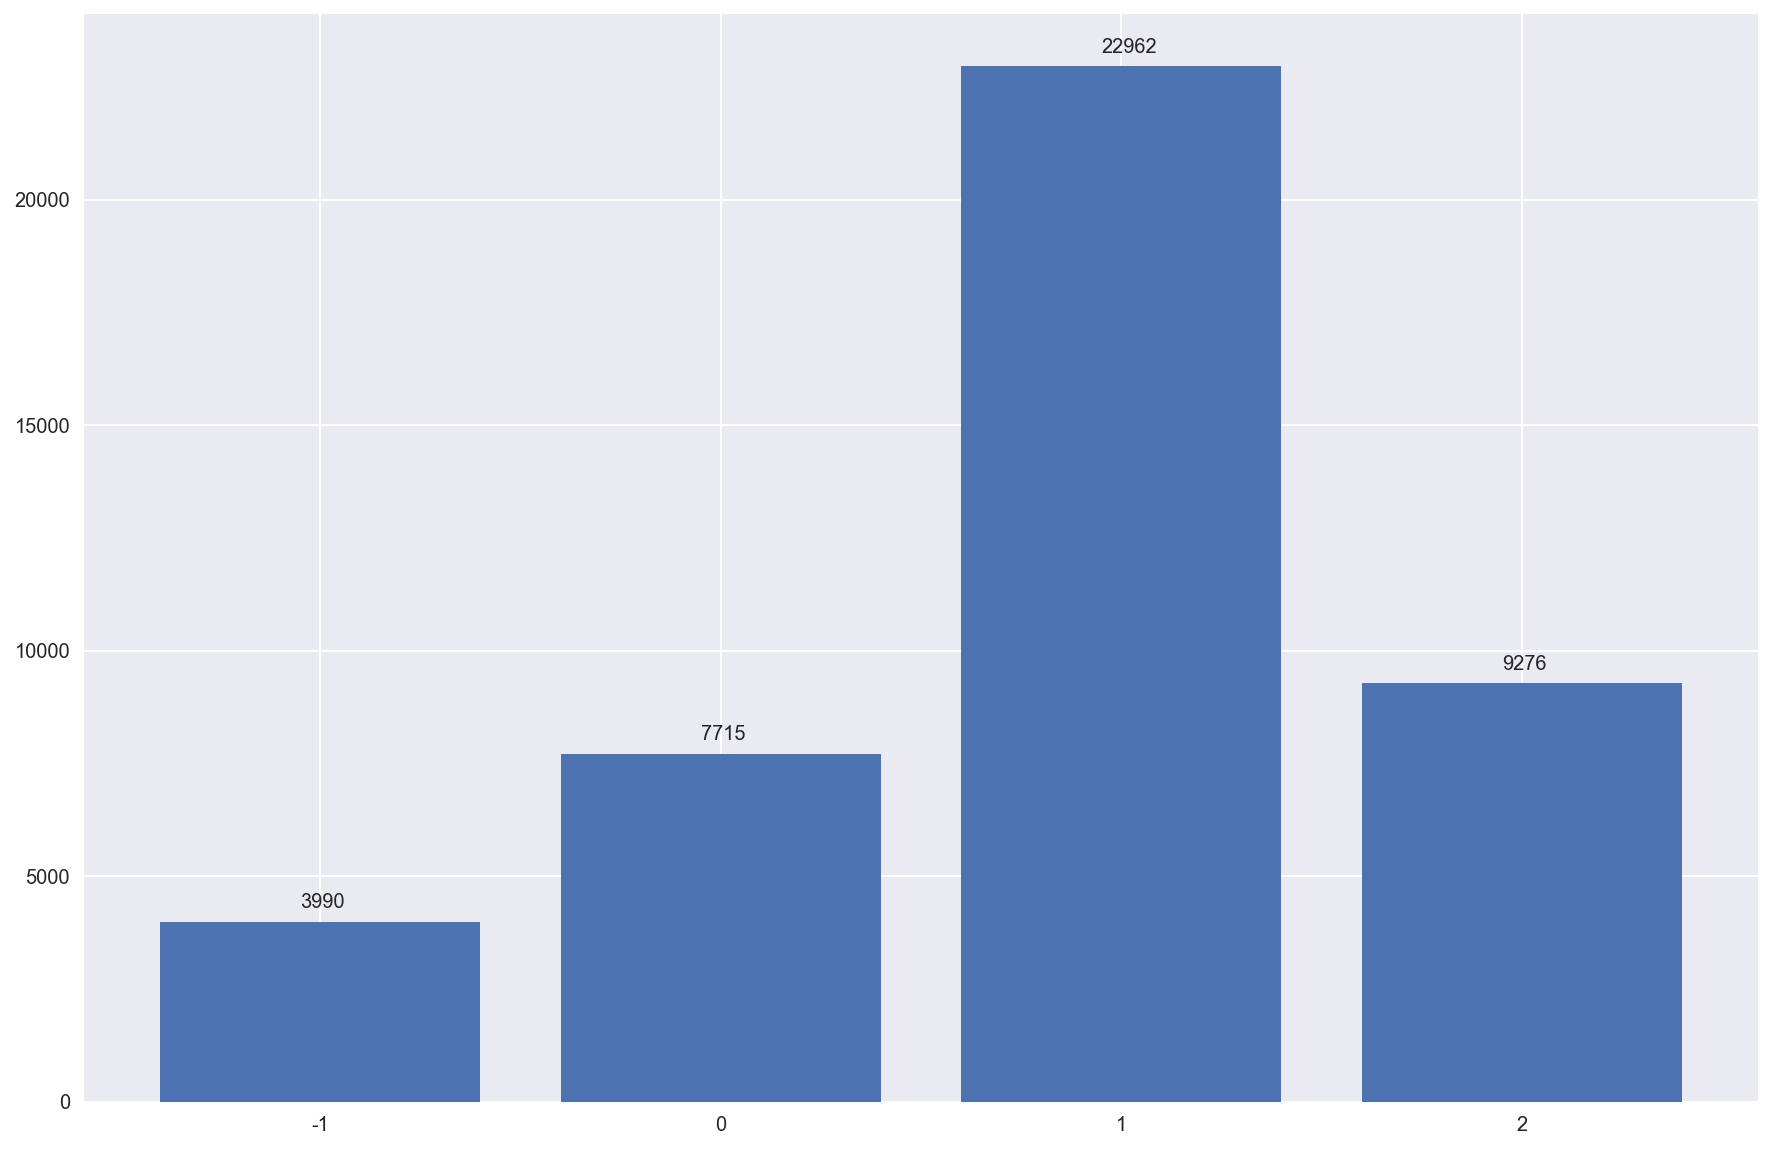

In [3]:
counts = data['sentiment'].value_counts().sort_index().values

plt.bar(range(-1, 3), counts, tick_label=range(-1, 3))

for index, value in enumerate(counts):
    plt.text(index - 1.05, value + 300, str(value))

plt.show()

It looks like our dataset is quite imbalanced: the vast majority of the examples we have express belief in anthropogenic climate change, while a very small minority hold the opposite position, or are neutral. This might have some severe effects on machine learning models we might want to train with it.

## Machine learning with text

Let's explore that idea by training a simple natural language processing (NLP) model to predict whether a message text holds either belief. 

We'll stick with some straightforward principles: first, we'll treat each message as a bag of words, that is we will ignore the order and structure of words, and just count how many times each appears. Second, we'll use a Decision Tree model to make decisions about what belief each message demonstrates, given the words that appear in it.

Let's go ahead and prepare our training and test data by including only messages annotated with either 1 or -1, then converting each message text to a list of word counts.

In [4]:
df = data.loc[(data.sentiment == 1) | (data.sentiment == -1)]

X = df.message
Y = df.sentiment

print(X.shape)
print(Y.shape)


(26952,)
(26952,)


In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import linear_model, model_selection
count_vect = CountVectorizer(strip_accents='unicode', stop_words='english')
X_counts = count_vect.fit_transform(X)

# Feature matrix shape
X_counts.shape

(26952, 47287)

Now that we have a set of feature vectors and labels, we can go ahead and split that into training and test sets, and train our model.

In [6]:
from sklearn import tree

X_train, X_test, y_train, y_test = model_selection.train_test_split(X_counts, Y, test_size=0.33, random_state=42)
X_train
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
preds = clf.predict(X_test)

In [7]:
from sklearn.metrics import accuracy_score


accuracy_score(y_test, preds)

0.8903878583473862

An accuracy of nearly 90% looks quite good, right? Well, that number may be giving us the wrong impression. Let's look at some more scoring metrics.

              precision    recall  f1-score   support

          -1       0.63      0.52      0.57      1250
           1       0.92      0.95      0.94      7645

    accuracy                           0.89      8895
   macro avg       0.78      0.74      0.76      8895
weighted avg       0.88      0.89      0.89      8895



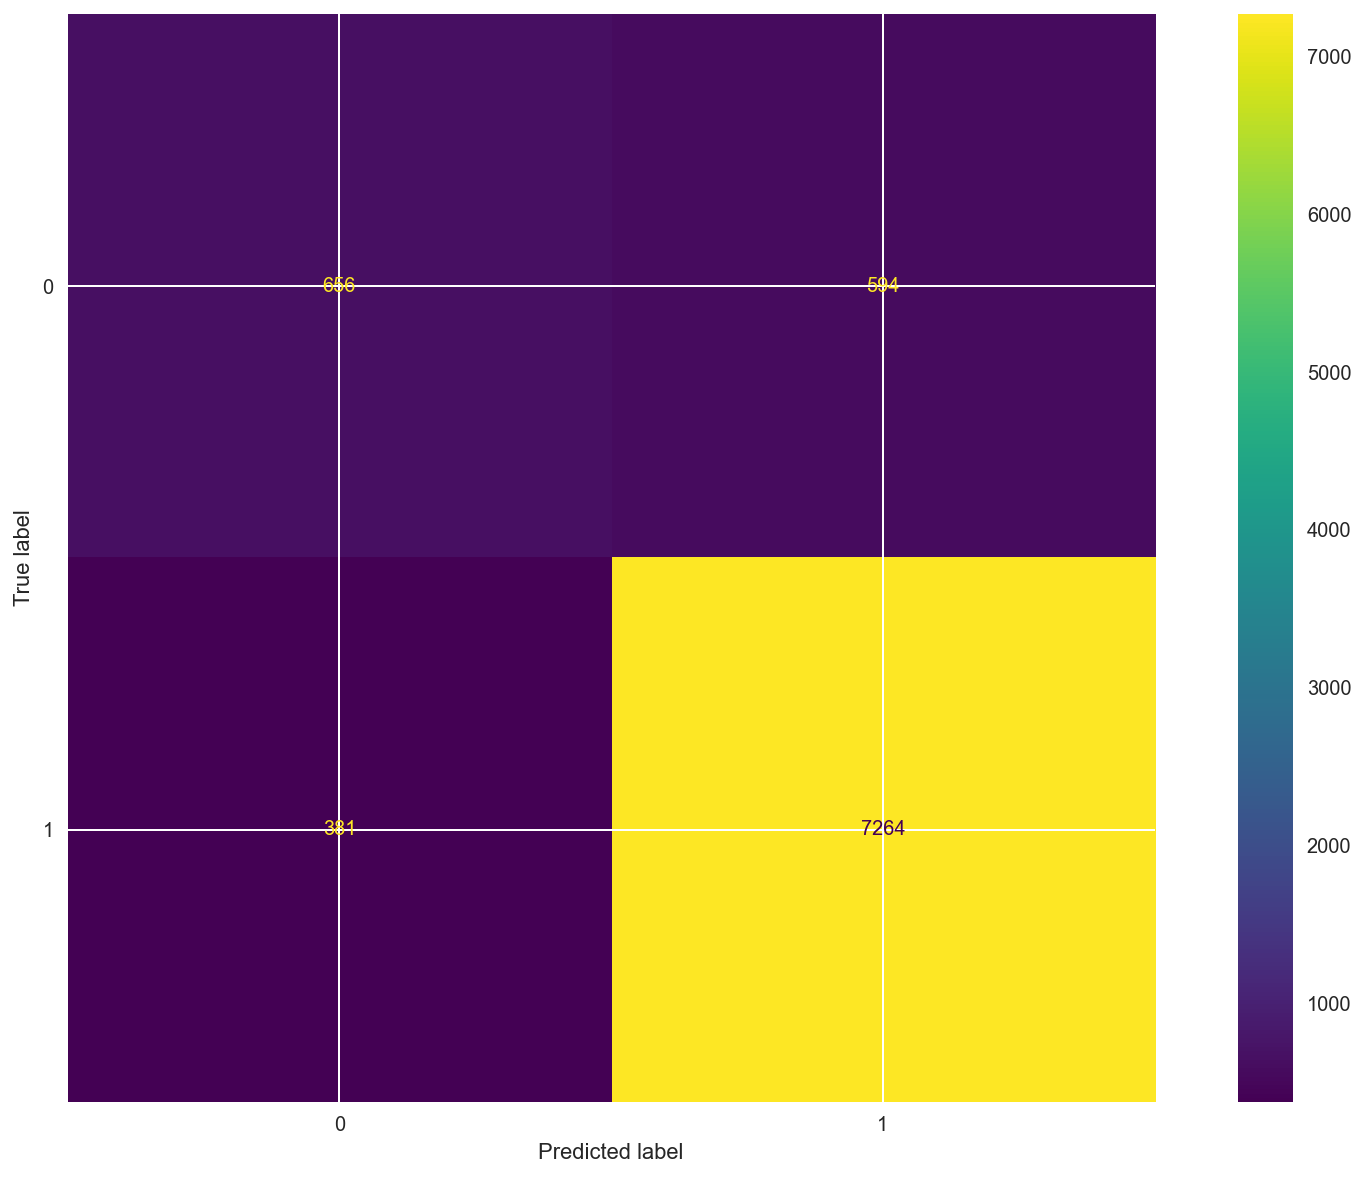

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print(classification_report(y_test, preds))

ConfusionMatrixDisplay(confusion_matrix(y_test, preds)).plot()
plt.show()

You can see that the classifier is almost always predicting that the message shows belief in anthropogenic climate change, regardless of what the message content looks like. Because our dataset is so imbalanced, with by far the majority of examples in the positive class, this means that most examples are going to be classified correctly by default, meaning that the accuracy score will be high, regardless of what our model is actually learning.

Using another metric which takes account of the ratio of false predictions as well as true predictions, like F1 or the Matthews Correlation Coefficient, gives us a much clearer understanding of what is going on.

# Our turn to answer

Indeed, the accuracy score is indeed too high and the descriptor correctly identifies that this model is likely to be outputting 1 simply because there is a class imbalance in the dataset. First, before actually addressing this class imbalance, we had to make sense of the lines of codes written up until now. 

## 1. The model is following the bag of words assumption

The bag of words is actually an euphemism. It's better to be called a bag of vectors assumption whereby the words that are spoken in the Twitter feeds are converted into vectors through one-hot encoding. It *was* quiet a robust preprocessing method in dealing with tasks involving language, such as spam detection back in the early days. The code that does this is the CountVectorizer() function. What happens is that it generates some sort of dictionary containing words that were parsed from the Twitter feeds following some heuristics of tokenization, such as splitting on whitespace and ignoring special symbols like @, # or :, which are quiet common in Twitter feeds. This leads us to having a dictionary like follows: 

In [9]:
count_vect.get_feature_names()

['00',
 '000',
 '00005',
 '000058',
 '0001jatt',
 '000s',
 '000yr',
 '001harpinder',
 '005c',
 '009barca',
 '00kevin7',
 '00pm',
 '00shfar1ja',
 '00sskwonxu',
 '00vfcrmuft',
 '00z7ad0zd5',
 '00zem9uqgt',
 '01',
 '018rvdntol',
 '01gnqpsrhs',
 '01kenyabiologics',
 '01pllh3xed',
 '01qdbqniog',
 '01tawpe7p3',
 '01vffxnna',
 '02',
 '024mxqpkot',
 '02gg2nz0ly',
 '02jbu2udyy',
 '03',
 '039',
 '039strch8n',
 '03ezntbl0c',
 '03lyjssbvi',
 '03o4itdvni',
 '03szjho5n2',
 '04',
 '04nlcpsaez',
 '05',
 '05giwkcj1f',
 '05vl8r1twg',
 '060x2hcwm2',
 '068wrr4gui',
 '06dmre71re',
 '06nahiyan',
 '06ny9fpkbq',
 '06uhpgk1bq',
 '07',
 '074abrjk0y',
 '07am',
 '07e5bdcy4p',
 '07hzxozi4r',
 '07xhaldnus',
 '08',
 '080yqpw1ng',
 '08a3wbvxap',
 '08fd2hz0ro',
 '08k8tx14mu',
 '08vb4d',
 '09',
 '094',
 '098my9kyoz',
 '09tnb97rrv',
 '0a',
 '0a3jod6lmh',
 '0advg1wgly',
 '0agi94rozy',
 '0ahzahfc0c',
 '0aiwukxb7y',
 '0akljmwrpz',
 '0amv4ttalj',
 '0aqkrolg1l',
 '0axqumyp8g',
 '0bama',
 '0bimw2glhh',
 '0blydqnbbn',
 '0btwbp

The first few words are indeed cryptic, but bear with me. These _are_ words parsed from the Twitter feeds, and they originate from the links that appear in individual Twitter feeds. Check for instance:

In [10]:
cryptic_string = '0f'  # You can copy and paste from the characters above
print(X[X.str.contains(cryptic_string)].iloc[0])
print()
print("Further down the list we actually can see some words: \n")
idx = 5888               # You can change this index and explore the dictionary for yourself
print(count_vect.get_feature_names()[idx])

RT @afenn11: Exxon backs Ã¢â‚¬Ëœserious actionÃ¢â‚¬â„¢ on climate change. Motive unclear, progress nonetheless. https://t.co/iCFHdY0f0I

Further down the list we actually can see some words: 

banfracking


Before even addressing the class imbalance issue, we have a problem where the tree classifier is not even being fed  words, given the poor parsing. These were poorly tokenized, and it's an inherent, fundamental limitation that affects its performance. The bag of words assumption also doesn't have any sense of the positions of the words, nor their meanings, only their **frequency**. 

Anyhow, a bit off topic, we came to solve class imbalance. This is because converting this problem into a natural language processing task using recurrent neural networks was a bit too elaborate for the only 3 hours we were given to discuss on this issue 😂. 

### 1. Amputate training data of the imbalanced label

The easiest method would be of course to randomly bring down the amount of training data with label 1 (believe in anthropogenic climate change) to similar number of the training data with label zero, which would be eliminating around 17000 thousand Twitter feeds. While controversial, it's a feasible first step to train the tree classifier and check whether it generalizes something. Even if it's a little bit. 

In [11]:
### 1. Amputation of data containing y = 1 label 
subsample_positive = data.loc[data.sentiment == 1].sample(n = 3990)  # hopefully this process is random and not biased
sample_negative = data.loc[(data.sentiment == -1)]
X = pd.concat([subsample_positive, sample_negative])                 # dataset with similar amount of positive and 
                                                                     # negative training data. 
Y = X.sentiment          # labels
X_amputate = X.message   # balanced now :)
X_amputate[X_amputate == "tiniebeany "]    # a word which appeared in the original dataset is now gone, 
                                           # which means it's a new vocabolary we're working with
X_counts = count_vect.fit_transform(X_amputate)   
X_counts = X_counts.toarray()
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_counts, Y, test_size=0.33, random_state=42)
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
accuracy_score(y_test, preds)


0.7513287775246773

              precision    recall  f1-score   support

          -1       0.75      0.75      0.75      1322
           1       0.75      0.75      0.75      1312

    accuracy                           0.75      2634
   macro avg       0.75      0.75      0.75      2634
weighted avg       0.75      0.75      0.75      2634



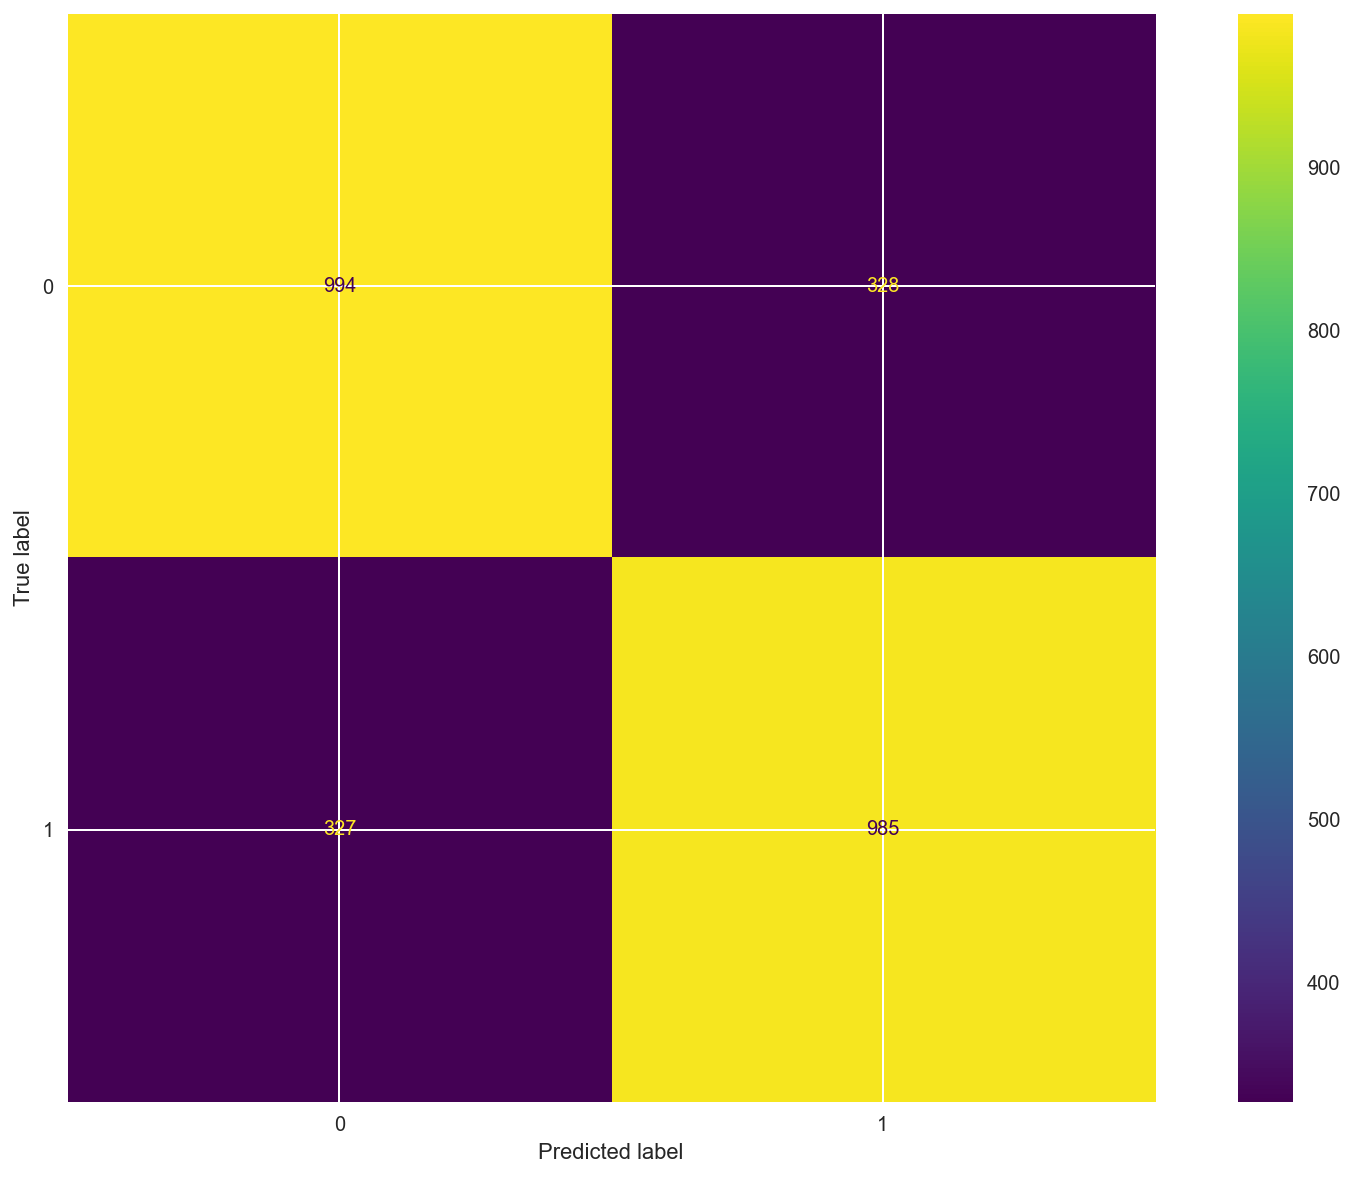

In [12]:
print(classification_report(y_test, preds))
ConfusionMatrixDisplay(confusion_matrix(y_test, preds)).plot()
plt.show()

The accuracy was brought down, which is a good sign because it means the class imbalance problem has been mitigated. Although I wanted propose a better solution (but couldn't since I had to leave for a meeting, hence I'm writing this notebook). 

### 2. Synthethise new data using MLE (or using the mean vector if you don't have enough computational power)
I proposed using maximum likelihood estimate to synthethise new vectors representing Twitter feeds of class 0. While it was also controversial, I think it's better than amputation since I really didn't have any control in deleting which data. It could have been that the sample could have been biased. 

Using MLE, on the other hand, I can first create a Normal distribution with mean vector the mean of all 3000 vectors of class 0, and variance the resulting covariance matrix to sample from such distribution vectors which would carry the characteristics of each other from the same distribution. I think it also suits this scenario since we're going for the bag of words assumption and we don't care about the *position of the words*. 

Sadly, the plan failed. Not because it's wrong, but rather because I don't have the computatioanl power (16.3 GB) to calculate a covariance matrix of shape (47287 * 47287). Also, even if I implemented a cheap workaround of a square matrix with random values, I didn't have the computational power to sample ~18000 vectors of shape (1, 47287) from a normal distribution specified by a mean vector and the above covariance matrix😭. 

A cheap workaround would be using the mean vector and synthethize new data by copying and stacking the mean vector about 18000 times. And then appending this matrix to the original dataset-generated matrix.   

In [13]:
## Solution 1. MLE (need greater computational power)
from scipy.stats import multivariate_normal
import numpy as np

### Have to run code in this sequence to ensure dimensionality coherence, i.e, 
### some words are exclusive to class 1. 
X = df.message
Y = df.sentiment
count_vect_mle = CountVectorizer(strip_accents='unicode', stop_words='english')
X_counts_mle = count_vect_mle.fit_transform(X)  


### Generate negative data using MLE
#synth_neg_data_array = synth_neg_data.toarray()
### Specify mean vector and covariance matrix calculated from
### the matrix of vectors of label -1
#norm_mean = np.mean(synth_neg_data_array, axis = 0) # based on x-axis
#@jit(target ="cuda")
#norm_cov = np.cov(synth_neg_data_array.T)                  # needs too much computational power😂
#shape = synth_neg_data_array.shape[1]
# norm_cov = np.random.randint(0, 1, size=(shape, shape))   # cheap workaround 😂
### Synthethize 18972 vectors with qualities of vectors that 
### had label -1 using np.random.multivariate_normal
synth_quantity = sum(df.sentiment == 1) - sum(df.sentiment == -1) 
#new_neg_data = np.random.multivariate_normal(norm_mean, norm_cov, synth_quantity)  # need > 8.33 GB 😂

In [14]:
### Solution 2: using the mean vector
from scipy import sparse

### Generate mean vector
synth_neg_data = np.mean(X_counts_mle[Y == -1].toarray(), axis = 0)
### Stack 18972 mean vectors onto one another
new_neg_data = np.vstack([synth_neg_data] * synth_quantity )
### Convert to sparse matrix to save space and combine to original X training data
new_neg_data = sparse.csr_matrix(new_neg_data)
new_X_counts_mle = sparse.vstack( (X_counts_mle, new_neg_data))
### Generate 18972 training negative labels 
neg_Y = pd.Series([-1] * synth_quantity )
Y_new = pd.concat([Y, neg_Y])
assert Y_new.shape[0] == new_X_counts_mle.shape[0]

In [15]:
### Train the classifier again
X_train, X_test, y_train, y_test = model_selection.train_test_split(new_X_counts_mle, Y_new, test_size=0.33, random_state=42)
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
accuracy_score(y_test, preds)

0.929726162982514

              precision    recall  f1-score   support

          -1       0.94      0.92      0.93      7570
           1       0.92      0.94      0.93      7585

    accuracy                           0.93     15155
   macro avg       0.93      0.93      0.93     15155
weighted avg       0.93      0.93      0.93     15155



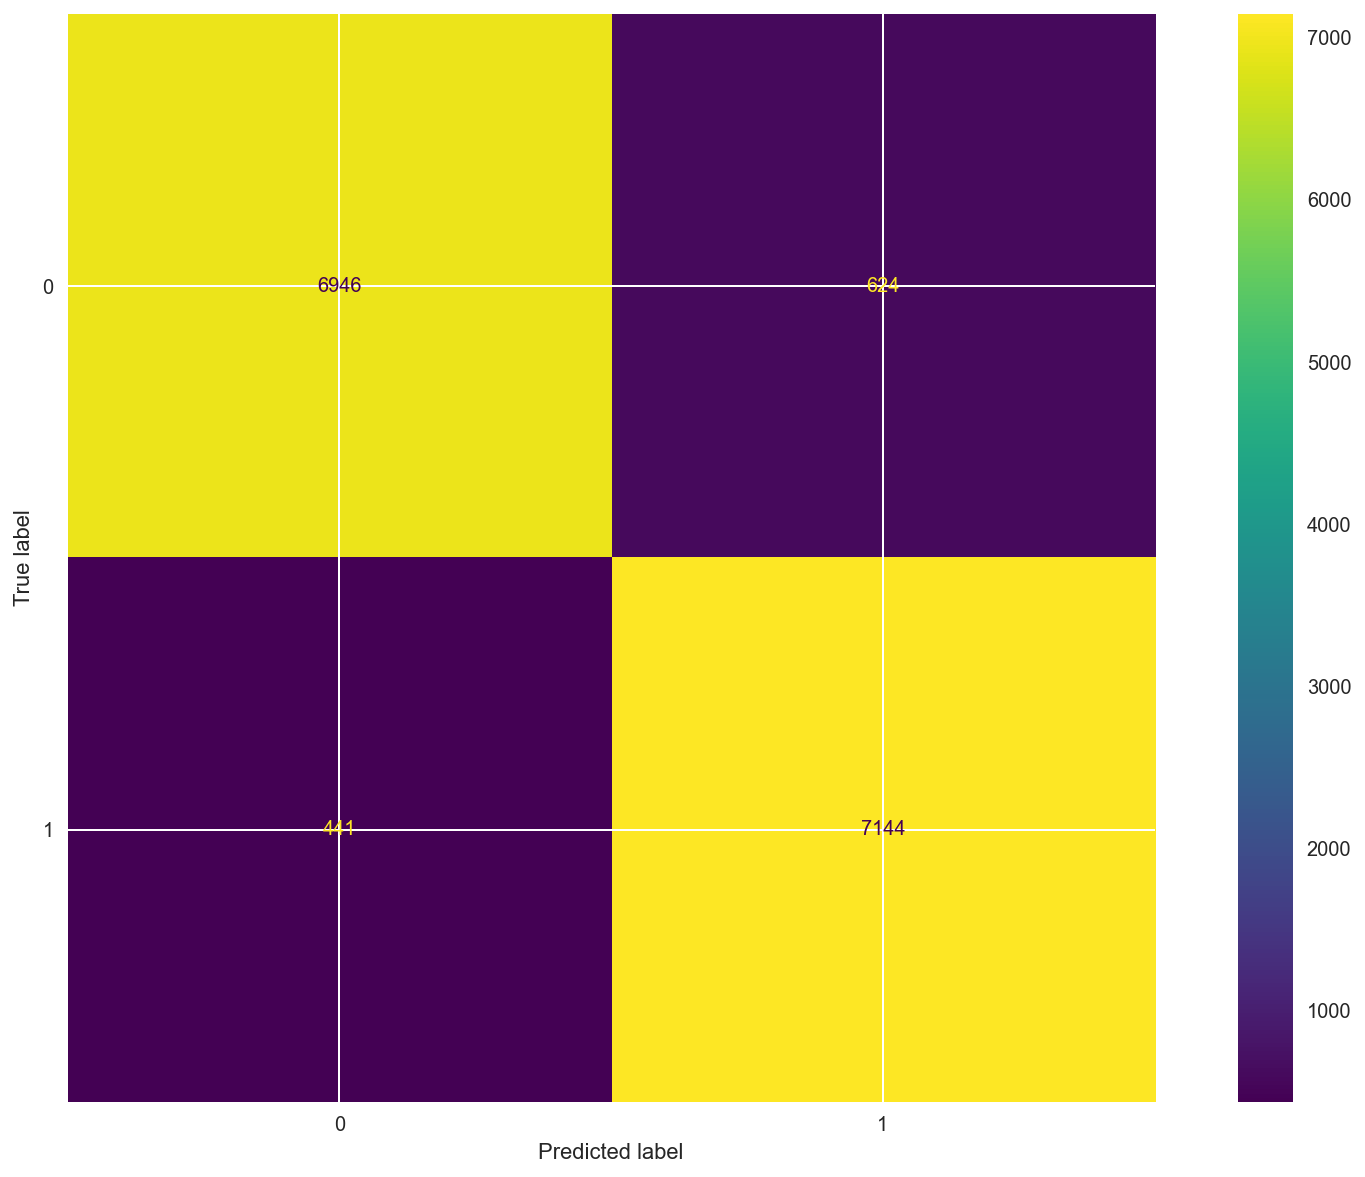

In [16]:
print(classification_report(y_test, preds))
ConfusionMatrixDisplay(confusion_matrix(y_test, preds)).plot()
plt.show()

Wow... A test accuracy of over 90%... Although I didn't even expect it given that I simply amplified the training data through mean imputation, I do reserve a lot of skepticism to the tree classifier. It's true that the test accuracy is robust given that after checking the confusion matrix, there was a significant increase in the amount of true negatives, as opposed to the original model which probably overfitted to positive training data given the class imbalance. Also, we do recall that the training and testing data were shuffled in the train_test_split() function. But, it's still a unavoidable truth that >18000 same vectors were input to the dataset. Since the tree classifier is a deterministic model, then it guarantees that at least it can classify about 18000 training instances correctly. After saying this, I consider it lucky for the model not to have misclassified the newly inserted 18000 instances 😂. Just kidding, they should have been learned during training.   

### 3. Some further ideas for better solutions

While in the data science group we mentioned natural language processing, this task lacks some fundamental features of NLP. For example, what's originally sequential data has been turned into static-sized vectors. There was, as I repeatedly say, no attempt at capturing the position nor meanings of the words. We could have addressed this question as an NLP task. But given the limited time back then (~3 hours), I don't think we could have explored more options. Especially since the choice of model, training, debugging (debugging), evaluation can take a lot of time. 

I, personally, may come back to this problem in the future to seek a better solution. Maybe using LSTM, recurrent neural networks for training, or maybe transformers? I'm not sure, they also require a lot of computation.

We also need to think about tokenization, especially avoiding websites or at least not parsing out cryptic words. 

# Ideas for discussion

Here's a set of questions that you might like to think about answering during your DSG challenge. If you don't see anything you're interested in answering, don't worry - feel free to come up with your own problem to solve or interesting piece of data to dig up.


*  __What topics do people who believe in human-caused climate change talk about, versus those who don't?
*  __Do believers/non-believers form networks - do they retweet each other a lot? You might have to think about linking accounts through matching message texts, or using retweets.
*  __Can you predict from a message text whether a person is going to believe in anthropogenic climate change better than the simple model we created?__ 
Yes, we humans actually understand the words used per tweet and can make sense of them or contextualize them. The bag of words don't care about meaning, nor even position. For example, a tweet claiming 'climate change is true' and 'climate change isn't true' would be only one split node different to one another in the tree classifier, but to humans they make a big difference.  
*  __What about if you disregard named entities, like the UN, IPCC, and so on? What does that do to your models' performance?
* __The class imbalance in the text dataset is quite bad, can you determine a way to address this to make machine learning easier to do?__
I used synthesis of mean vector to amplify the training data to balance out negative and positive classes. Despite this simple, cheap workaround since MLE failed given a lack of computational power, there was a surprising step-up in accuracy that was robust as shown by the results of the confusion matrix. Albeit there are a lot of improvements such as cleaning of data, better tokenization, having a vocabulary to make sense of the words and take into acccount position.  


# Presenting your work

The final outcome of your DSG challenge will be a very short presentation delivered by your facilitator. We're looking for something that can provide the following:

* An interesting finding for discussion, which you can illustrate with a single slide
* A five minute slot for talking about your experiences during the challenge

That last point is important: we want this to be a collaborative experience, so be prepared that your facilitator might talk about some of the things you come up with during the event. Remember, this event is for the benefit of all participants, so remain polite, collegial, and constructive at all times.